In [16]:
import pandas as pd
import math
import numpy as np
import random

In [ ]:
import numpy as np

def calculate_energy(chain:np.typing.NDArray, h_indices:np.typing.NDArray):
    h_coords = chain[h_indices]
    
    # Broadcast of (N, 1, 3) - (1, N, 3) => (N, N, 3)
    diffs = h_coords[:, np.newaxis, :] - h_coords[np.newaxis, :, :]
    dists = np.abs(diffs).sum(axis=-1)
    index_diffs = np.abs(h_indices[:, np.newaxis] - h_indices[np.newaxis, :])
    valid_contacts = ((dists == 1) & (index_diffs > 1)).sum()
    
    return -valid_contacts / 2

def perturb(chain: np.typing.NDArray):
    chain_cp = chain.copy()
    pivot_index = random.randint(1, len(chain_cp) - 2)
    pivot_point = chain_cp[pivot_index]
    rotation_type = random.choice([90, -90])

    for i in range(pivot_index + 1, len(chain_cp)):
        rel_point = chain_cp[i] - pivot_point

        # Rotation math
        if rotation_type == 90:
            new_x, new_y = -rel_point[1], rel_point[0]
        elif rotation_type == -90:
            new_x, new_y = rel_point[1], -rel_point[0]
        else:
            new_x, new_y = -rel_point[0], -rel_point[1]

        chain_cp[i] = [new_x + pivot_point[0], new_y + pivot_point[1]]

    return chain_cp

def have_collision(chain:np.typing.NDArray):
    unique_beads = np.unique(chain, axis=0)
    return len(unique_beads) < len(chain)

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_data(chain:np.typing.NDArray, sequence):
    df = pd.DataFrame( {'x':chain.T[0], 'y':chain.T[1], 'val': [c for c in sequence]} )
    ax = sns.lineplot(data=df, x='x', y='y', sort=False, color='black', alpha=0.5, estimator=None)
    ax.set_aspect('equal', adjustable='datalim')
    sns.scatterplot(data=df, x='x', y='y', hue='val', s=60, zorder=10)
    return plt.show()

In [26]:
# A simple protein sequence: Hydrophobic (H) and Polar (P)
sequence = "HHPPHHHPHHPPPHHPPHHPPPHHHHPPPPPHPHHPPHHHPHHPPPHHPPHHPPPHHHHPPPPPHPHHPPHHHPHHPPPHHPPHHPPPHHHHPPPPPHP"
chain = np.array( [(i,0) for i in range(len(sequence))] ) #Todo: put 3 coords later
h_indices = np.array([i for i, char in enumerate(sequence) if char == 'H'])

turns = 20000
energy = float("inf")
energy_hist = []
best_chain = chain.copy()
T_hist = []

def get_temperature(i, turns, T_max=100.0, T_min=0.1):
    fraction = i / turns
    current_T = T_max * ((T_min / T_max) ** fraction)
    return current_T

for i in range(turns):
    T = get_temperature(i, turns)
    new_chain = perturb(chain)
    if have_collision(new_chain):
        continue
        
    new_energy = calculate_energy(new_chain, h_indices)
    delta_E = new_energy - energy
    
    if delta_E <= 0:
        chain = new_chain
        energy = new_energy
    else:
        probability = math.exp(-delta_E / T)
        if random.random() < probability:
            chain = new_chain
            energy = new_energy
            
    energy_hist.append(energy)
    best_chain = chain if energy == min(energy_hist) else best_chain
    T_hist.append(T)



<Axes: >

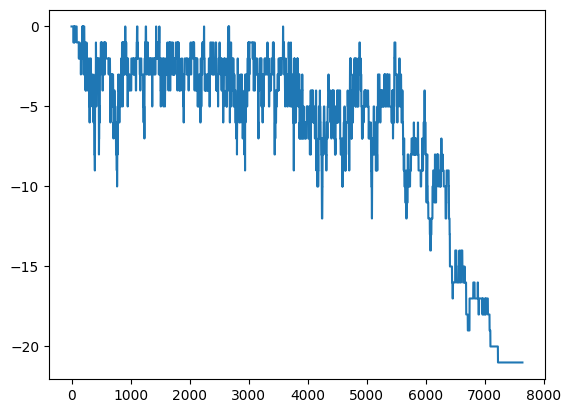

In [27]:
sns.lineplot(energy_hist)

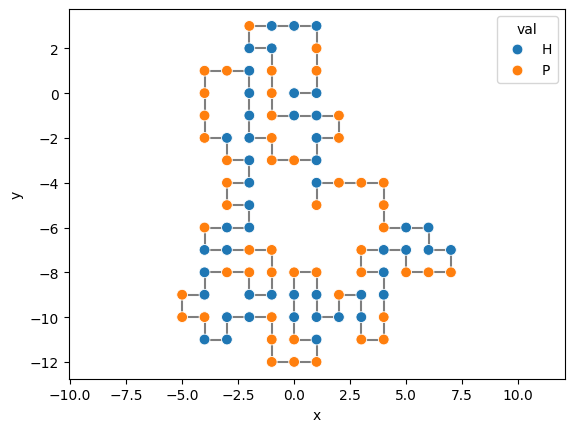

In [28]:
plot_data(best_chain, sequence)